<img src='https://imgur.com/G7R8fkB.png'>
ref: https://imgur.com/G7R8fkB

<h1>1. Business Problem </h1>

<p>
The goal of this competition is to provide a simple extension to the <b>Classic MNIST dataset</b> competition we're all familiar with. Instead of using Arabic numerals, it uses a recently-released dataset of Kannada digits. Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script</p>
<p>wikipedia: https://en.wikipedia.org/wiki/Kannada </p>

<h2> 1.2 Problem Statement </h2>

<p>
Kaggle provided a large amount of pixel data and a mapped class labels for each image data point and we have to build a image classifier.
</p>

<h2> 1.3 Sources </h2>

<ul>
<li> https://www.kaggle.com/c/Kannada-MNIST/overview</li>
<li> https://www.kaggle.com/c/Kannada-MNIST/discussion</li>
</ul>

<h2>1.4 Real world Objectives  </h2>

Objectives:
1. classify the image based on the pixel data provided amoung the 10 different labels.
2. Build model that can classify images with Maximum Accuracy (Accuracy is the number of correct predictions made divided by the total number of predictions made multiplied by 100 to turn it into a percentage)
<br>

<h1> 2. Machine Learning Problem </h1>

<h2>2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> Get the data from : https://www.kaggle.com/c/Kannada-MNIST/data </p>
<p> 
The data files train.csv contain gray-scale images of hand-drawn digits, from zero through nine, in the Kannada script.
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255
</p>
<p>
The training data set, train.csv, also has 785 columns. The first column, called label, is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
</p>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

* For a given pixel data we need to classify the image as digit and the given problem is a muliticlass Classification problem 
* It can also seen as a image processing problem 

<h3> 2.2.2 Performance metric </h3>


<ul>
<li> Accuracy score: https://en.wikipedia.org/wiki/Accuracy_and_precision </li>
<li> Categorical_crossentropy: https://keras.io/losses/ </li>
</ul>

<h3> 2.2.3 Machine Learning Objective and Constraints </h3>

1. Maximize Multiclass Accuracy.
2. Minimize Categorical_crossentropy(Multi-class-LogLoss) across all lables.

<h2> 3. Exploratory Data Analysis and Preprocessing </h2> </h2>

In [0]:
# All Imports
import pandas as pd
import numpy as np
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Flatten,MaxPooling2D,Dense, Dropout, Flatten, Conv2D
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical 
import matplotlib.cm as cm
import itertools
%matplotlib inline

data=pd.read_csv("train.csv")
Y=np.array(data['label'])
data.drop(axis=1,columns='label',inplace=True)
print("Dataset Shape:",data.shape)

Dataset Shape: (60000, 784)


In [0]:
# checking nan_values
print("Number of Nan values in our Data : ", sum(data.isnull().any()))

Number of Nan values in our Data :  0


In [0]:
# checking for duplicates
print("Number of Duplicates in Data : ", sum(data.duplicated()))

Number of Duplicates in Data :  0


In [0]:
print("Basic Information about Data:")
data.info()

Basic Information about Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 358.9 MB


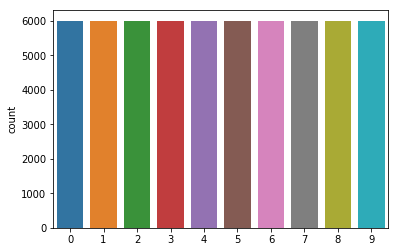

In [0]:
# checking distribution
Y=np.array(data['label'])
sns.countplot(Y)

* we have a well balanced Dataset

In [0]:
# function confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'
cm_cmap=plt.cm.Greys
class_labels=[0,1,2,3,4,5,6,7,8,9]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<h2> 4. Train test split </h2>

In [0]:
# train test split
train, test, y_train, y_test = train_test_split(data, Y,test_size=0.3,random_state=42,stratify=Y)
train.head(4)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
6724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test.head(4)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
15107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34485,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h2> 5. Data Preparation </h2>

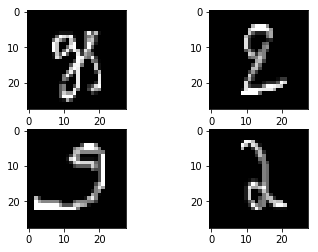

In [0]:
# converting data to format that model can understand
# train data preparation
train_data=[]
from tqdm import tqdm
for i in range(train.shape[0]):
    num=np.array(train[i:i+1])
    num=num.ravel()
    num=num.reshape((28,28))
    train_data.append(num)
x_train=np.array(train_data)

# test data preparation
test_data=[]
for i in range(test.shape[0]):
    num=np.array(test[i:i+1])
    num=num.ravel()
    num=num.reshape((28,28))
    test_data.append(num)
x_test=np.array(test_data)

# images
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(x_train[3],cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(x_train[8],cmap='gray')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(x_train[2],cmap='gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(x_train[20],cmap='gray')

In [0]:
#initializtion
batch_size = 128
num_classes = 10
epochs = 5

# funct to convert one_hot_to_scalars
def one_hot2indices(one_hots):
    indices = []
    for one_hot in one_hots:
        indices.append(np.argmax(one_hot))
    return indices

# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#type casting to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normaliztion
x_train /= 255
x_test /= 255

#printing size
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# scalar to one-hot-encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (42000, 28, 28, 1)
42000 train samples
18000 test samples


<h2> 6. Building Models </h2>
<h2> Model - 1 </h2>
<h3> Architecture: Con2D X 3 - Max2D - Con2D X 2 - Con2D - Max2d - Flatten - Dense - Dropout - Dense</h3>

In [0]:
# Use Grid Search the batch size and epochs
from tensorflow import set_random_seed
from numpy.random import seed
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import warnings
warnings.filterwarnings('ignore')
np.random.seed(7)
set_random_seed(2)
seed(1)

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=192, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=192, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64,128]
epochs = [20, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=10)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Cross-validation Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 192)       221376    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 192)       

log_loss: 0.03741
accuracy_score: 0.99567


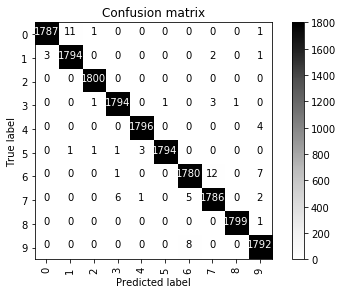

In [26]:
y_test_acc=np.array(one_hot2indices(y_test))
predit=np.array(grid.predict_proba(x_test))
print("log_loss:",np.round(log_loss(y_test_acc, predit),5))
predit=np.array(grid.predict(x_test))
print("accuracy_score:",np.round(accuracy_score(y_test_acc, predit),5))
plot_confusion_matrix(confusion_matrix(y_test_acc,predit), classes=class_labels, normalize=False, title='Confusion matrix',cmap = cm_cmap)

<h2>Model - 2 </h2>
<h3>Architecture: Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense
with Reducing Learning Rate</h3>

In [0]:
import itertools
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# build Sequential model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.summary()

# compile model
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                           min_lr=0.00001)

# fit model
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=128, 
                 epochs=30,
                 validation_data=(x_test, y_test), 
                 callbacks=[learning_rate_reduction],
                 verbose=1, 
                 shuffle=True)

# evalute model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)        

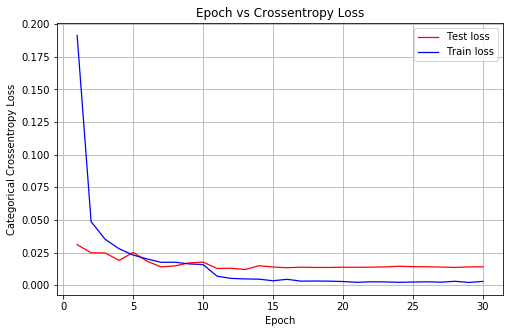

In [0]:
# epoch list
epochs = list(range(1,30+1))

# Obtaining loss
validation_loss = hist.history['val_loss']
train_loss = hist.history['loss']

# ploting Epoch vs Crossentropy Loss    
plt.figure(figsize=(8,5))
plt.plot(epochs,validation_loss,'r',label='Test loss',linewidth=1.25)
plt.plot(epochs,train_loss,'b',label='Train loss',linewidth=1.25)
plt.ylabel('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.title('Epoch vs Crossentropy Loss')
plt.grid()
plt.legend()
plt.show()

accuracy_score: 0.99667


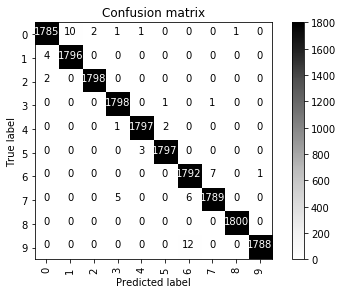

In [0]:
y_test_acc=np.array(one_hot2indices(y_test))
predit=np.array(one_hot2indices(model.predict(x_test)))
print("accuracy_score:",np.round(accuracy_score(y_test_acc, predit),5))
plot_confusion_matrix(confusion_matrix(y_test_acc,predit), classes=class_labels, normalize=False, title='Confusion matrix',cmap = cm_cmap)

<h2>Model - 3</h2>
<h3>Architecture: Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense<br>
 with Reducing Learning Rate + Data Agumentation</h3>

**DATA AGUMENTATION**:
* Image data augmentation is perhaps the most well-known type of data augmentation and involves creating transformed versions of images in the training dataset that belong to the same class as the original image.
* Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.

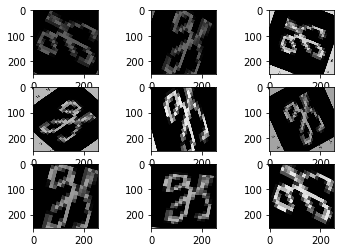

In [14]:
# citation:https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('img5.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90,brightness_range=[0.2,1.0],zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# build Sequential model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Compile model
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)
# Data Agumentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False) 

# Model Training
hist = model.fit_generator(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = 20, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // 128
                              ,callbacks=[learning_rate_reduction])

# Model Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
 - 16s - loss: 0.3365 - acc: 0.8902 - val_loss: 0.0657 - val_acc: 0.9816
Epoch 2/20
 - 15s - loss: 0.0916 - acc: 0.9725 - val_loss: 0.0262 - val_acc: 0.9924
Epoch 3/20
 - 15s - loss: 0.0654 - acc: 0.9818 - val_loss: 0.0226 - val_acc: 0.9939
Epoch 4/20
 - 15s - loss: 0.0555 - acc: 0.9836 - val_loss: 0.0278 - val_acc: 0.9940
Epoch 5/20
 - 15s - loss: 0.0481 - acc: 0.9861 - val_loss: 0.0168 - val_acc: 0.9948
Epoch 6/20
 - 15s - loss: 0.0417 - acc: 0.9880 - val_loss: 0.0184 - val_acc: 0.9939
Epoch 7/20
 - 15s - loss: 0.0411 - acc: 0.9884 - val_loss: 0.0173 - val_acc: 0.9949
Epoch 8/20
 - 15s - loss: 0.0381 - acc: 0.9891 - val_loss: 0.0185 - val_acc: 0.9953

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 9/20
 - 15s - loss: 0.0279 - acc: 0.9921 - val_loss: 0.0129 - val_acc: 0.9962
Epoch 10/20
 - 15s - loss: 0.0259 - acc: 0.9921 - val_loss: 0.0119 - val_acc: 0.9966
Epoch 11/20
 - 15s - loss: 0.0230 - acc: 0.9936 - val_loss: 0.0112 - val_acc:

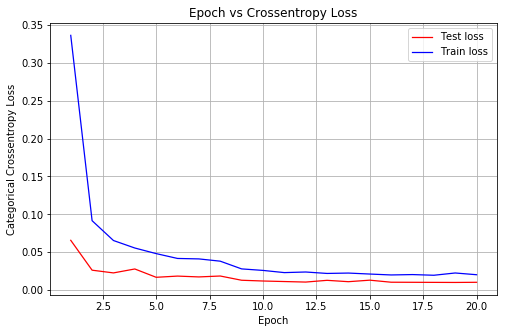

In [0]:
# epoch list
epochs = list(range(1,20+1))

# Obtaining loss
validation_loss = hist.history['val_loss']
train_loss = hist.history['loss']

# ploting Epoch vs Crossentropy Loss    
plt.figure(figsize=(8,5))
plt.plot(epochs,validation_loss,'r',label='Test loss',linewidth=1.25)
plt.plot(epochs,train_loss,'b',label='Train loss',linewidth=1.25)
plt.ylabel('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.title('Epoch vs Crossentropy Loss')
plt.grid()
plt.legend()
plt.show()

accuracy_score: 0.99728


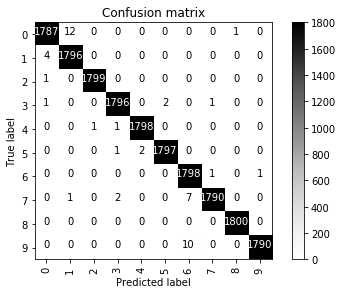

In [0]:
y_test_acc=np.array(one_hot2indices(y_test))
predit=np.array(one_hot2indices(model.predict(x_test)))
print("accuracy_score:",np.round(accuracy_score(y_test_acc, predit),5))
plot_confusion_matrix(confusion_matrix(y_test_acc,predit), classes=class_labels, normalize=False, title='Confusion matrix',cmap = cm_cmap)

In [33]:
# Architecture of layers
arch1="Con2D X 3 - Max2D - Con2D X 2 - Con2D - Max2d - Flatten - Dense - Dropout - Dense."
arch2="Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense>(Ru-LE)."
arch3="Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense>(Ru-LE+DA)."

ls=[arch1,arch2,arch3]
for i,l in enumerate(ls,1):
    print(" MODEL-{0} Architecture: {1}\n".format(i,l))
    
from prettytable import PrettyTable
T = PrettyTable()
print("\t  DEEP LEARNING MODELS")
T.field_names = ["Models","Test-Loss","Test-Accuracy"]
T.add_row(["Model-1","0.03741","99.56 %"])
T.add_row(["------","--------","------"])
T.add_row(["Model-2","0.01413", "99.66 %"])
T.add_row(["------","--------","------"])
T.add_row(["Model-3","0.01015", "99.72 %"])
print(T)

 MODEL-1 Architecture: Con2D X 3 - Max2D - Con2D X 2 - Con2D - Max2d - Flatten - Dense - Dropout - Dense.

 MODEL-2 Architecture: Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense>(Ru-LE).

 MODEL-3 Architecture: Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense>(Ru-LE+DA).

	  DEEP LEARNING MODELS
+---------+-----------+---------------+
|  Models | Test-Loss | Test-Accuracy |
+---------+-----------+---------------+
| Model-1 |  0.03741  |    99.56 %    |
|  ------ |  -------- |     ------    |
| Model-2 |  0.01413  |    99.66 %    |
|  ------ |  -------- |     ------    |
| Model-3 |  0.01015  |    99.72 %    |
+---------+-----------+---------------+


<h2>Steps Followed to solve this problem</h2>


** 1. Problem Definition:** This include clearly understanding the problem being solved
  * Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script.This project is to build a model that classify image as kannada language digit from 0 - 9.

** 2. Gathering Data:** The quality and quantity of data that you gather will determine how good your predictive model can be.
  * This dataset is collected from kaggle which publicly avaliable for experimentation and competitions.
  * dataset link: https://www.kaggle.com/c/Kannada-MNIST/data

** 3. Data Analysis and Preprocessing :** This includes gaining insights from data to solve a problem and cleaning unwanted data
   * The Data set contains  contains pixel data of 785 columns : image, label
   * Preprocessing includes:
      - Checking for Nan Values. 
      - Checking for Duplicates in Data. 

** 4. Data preparation:** Discovering the format of data that the machine learning model can understand and construction of  features like:
 * There are 754 pixel data coloumns which has to be reshaped to (28, 28) to represent an image and then further has to be reshaped to (number_of_datapoints, 28, 28, 1) to build Deep CNN Model.
 * This step also include converting labels to One-hot-encoding.
 

** 5. Choosing a Model and Methods:** There are many models that researchers have created over the years but in this case study we will experiment with a bunch of  algorithms 
 * we use Conventional Neural Network Deep Learning Model with Various Architectures :
  * Model-1:Con2D X 3 - Max2D - Con2D X 2 - Con2D - Max2d - Flatten - Dense - Dropout - Dense.
  * Model-2:Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense >>with Reducing Learning Rate.
  * Model-3:Con2D X 2 - Max2D - Dropout - Con2D X 2 - Max2d - Dropout - Flatten - Dense - Dropout - Dense Reducing_Learning_Rate + Data_Agumentation.
                   
                   








** 6. Training:** The is considered the bulk of machine learning  which refer to Building a Machine Learning model
 * In this case study we make a 70-30 Split for Training, Testing and for building a model.

** 7. Evaluation:**  This is where we evaluate model performance how good is our model
  * For Deep learning model goal is to reduce Multi-class log loss
  * Use  Accuracy as main Mertic to measure performance of Model
  * Also use Confusion Matrix as mertic of Reference

** 8. Improve Results(Parameter Tuning):**  This is where Hyper parameter tuning is done to gain best model possible
  * GridSearchCV for Hyper Parameter Tunning on all models.
  * Try a bunch of Hyper Parameter values to increase  Accuracy  more as possible.
  * Use Data-Agumentation and callback-reduce learning rate on val_loss method to enhance results.
  * Performance can be futher improved by experimenting histogram of oriented gradients(HOG) on images.

** 9. Present results:** The results of model performance for this case study is Represented in pretty table above

**CONCLUSION:**
*  In the real world, domain-knowledge, EDA and feature-engineering matter most.
* The high train-loss initially for Model-3 is due to Data Agumentation.
* Altering Learning rate after some epochs improve test accuracy significantly.
* There is still confusion between digit one,zero and six,nine labels even for best model.

Finally our best Deep learning model is Conventional Neural Network Model-3 Architecture with 99.72% Accuracy which out perform every other model.